### Imports

In [10]:
import time
import json
import datetime
import numpy as np
import pandas as pd

# import plotly dash components
import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import commonteamroster, teamdashlineups

import scienceplots
plt.style.use(['grid','science','notebook'])

### Read Data & Clean the Data

In [17]:
ballhog_df = pd.read_csv('data/ball-hog-rate/ball-hog-rates_regular_season_2013_23_w_age_exp_pos.csv')
ballhog_df['POS_EST'] = ballhog_df['POS_EST'].astype(np.float64)
lineups_df = pd.read_csv('data/starting-lineups/2022-23_starting_lineups.csv')

print('The Number of Processed Rows:', len(ballhog_df))

ballhog_df.head()

The Number of Processed Rows: 5801


,SEASON,MINUTES_ON,PLAYER_NAME,PLAYER_ID,TEAM_ID,SECONDS_PER_POSS_OFFENSE_PLAYER_ON,TIME_OF_POSS,TEAM,OFF_POSS,BALL_HANDLE%,AGE,EXP,POS_EST
0,2022-23,83,A.J. Lawson,1630639.0,1610612742,14.477,3.5,DAL,230.0,6.3,22.0,0.0,2.75
1,2022-23,2,A.J. Lawson,1630639.0,1610612750,12.000,0.0,MIN,5.0,0.0,22.0,0.0,2.99
2,2021-22,94,Bruno Fernando,1628981.0,1610612745,14.121,4.5,HOU,198.0,9.7,23.0,2.0,5.00
3,2021-22,58,Bruno Fernando,1628981.0,1610612738,13.843,2.7,BOS,134.0,8.7,23.0,2.0,4.88
4,2020-21,226,Bruno Fernando,1628981.0,1610612737,14.698,9.3,ATL,480.0,7.9,22.0,1.0,5.00


##### Get Starters for 2022-23

In [446]:
# get list of teams and sort them
team_lst = teams.get_teams()
sorted_team_lst = sorted(team_lst, key=lambda x: x['full_name'])

# create dictionary mappings of city to IDs and IDs to team names
city_to_id_map = dict()
id_to_team_name = dict()
abb_to_id_map = dict()

# map values to each other
for team in sorted_team_lst:
    city_to_id_map[team['city']] = team['id']
    id_to_team_name[team['id']] = team['full_name']
    abb_to_id_map[team['abbreviation']] = team['id']

# ESPN names the city weirdly for the LA teams...
city_to_id_map['LA Clippers'] = 1610612746
city_to_id_map['LA Lakers'] = 1610612747

# create new columns in lineups dataframe
lineups_df['TEAM_ID'] = lineups_df['TEAM'].map(city_to_id_map)
lineups_df['TEAM_NAME'] = lineups_df['TEAM_ID'].map(id_to_team_name)

# transform the lineups dataframe and create a new dataframe of all starters and their respective positions
starters_df = pd.melt(lineups_df, id_vars=['TEAM', 'TEAM_ID', 'TEAM_NAME'], value_vars=['PG', 'SG', 'SF', 'PF', 'C'], var_name='POSITION', value_name='PLAYER')
starters_df = starters_df.rename(columns={'PLAYER': 'PLAYER_INITIAL_LAST'}).drop(columns=['TEAM'])

print('The Number of Starting Players:', len(starters_df))

starters_df.head()

The Number of Starting Players: 150


,TEAM_ID,TEAM_NAME,POSITION,PLAYER_INITIAL_LAST
0,1610612737,Atlanta Hawks,PG,T. Young
1,1610612738,Boston Celtics,PG,M. Smart
2,1610612751,Brooklyn Nets,PG,S. Dinwiddie
3,1610612766,Charlotte Hornets,PG,T. Rozier
4,1610612741,Chicago Bulls,PG,P. Beverley


In [117]:
# get ball-hog rates from current players only
current_players = ballhog_df[ballhog_df['SEASON'] == '2022-23'].reset_index(drop=True)
current_players['PLAYER_INITIAL_LAST'] = current_players['PLAYER_NAME'].apply(lambda x: f"{x[0].upper()}. {' '.join(x.split(' ')[1:])}")
#current_players['PLAYER_INITIAL_LAST'] = current_players['PLAYER_NAME'].apply(lambda x: f"{x[0].upper()}. {x.split(' ')[-1]}")

# mark all the current starters
ballhog_starters_df = pd.merge(starters_df, current_players, on=['TEAM_ID','PLAYER_INITIAL_LAST'], how='left')

print('The Number of Starting Players:', len(ballhog_starters_df))

# j.williams edge-case
ballhog_starters_df = ballhog_starters_df[~((ballhog_starters_df['PLAYER_NAME'] == 'Jaylin Williams') & (ballhog_starters_df['POSITION'] == 'PF'))]
ballhog_starters_df = ballhog_starters_df[~((ballhog_starters_df['PLAYER_NAME'] == 'Jalen Williams') & (ballhog_starters_df['POSITION'] == 'C'))]

print('The Number of Starting Players after removing J.Williams edge case:', len(ballhog_starters_df))

ballhog_starters_df.head()

The Number of Starting Players: 152
The Number of Starting Players after removing J.Williams edge case: 150


,TEAM_ID,TEAM_NAME,POSITION,PLAYER_INITIAL_LAST,SEASON,PLAYER_NAME,PLAYER_ID,SECONDS_PER_POSS_OFFENSE_PLAYER_ON,TIME_OF_POSS,TEAM,OFF_POSS,BALL_HANDLE%
0,1610612737,Atlanta Hawks,PG,T. Young,2022-23,Trae Young,1629027.0,13.671,579.9,ATL,5443.0,46.8
1,1610612738,Boston Celtics,PG,M. Smart,2022-23,Marcus Smart,203935.0,14.458,247.2,BOS,4026.0,25.5
2,1610612751,Brooklyn Nets,PG,S. Dinwiddie,2022-23,Spencer Dinwiddie,203915.0,14.964,208.1,BKN,1846.0,45.2
3,1610612766,Charlotte Hornets,PG,T. Rozier,2022-23,Terry Rozier,1626179.0,14.401,362.7,CHA,4636.0,32.6
4,1610612741,Chicago Bulls,PG,P. Beverley,2022-23,Patrick Beverley,201976.0,15.442,80.8,CHI,1183.0,26.5


##### Separate DataFrame by Position

In [141]:
eligible_df = ballhog_df[ballhog_df['MINUTES_ON'] >= 500].reset_index(drop=True)

print('The Number of Players with at least 500 Minutes Played:', len(eligible_df))

guards_df = eligible_df[eligible_df['POS_EST'] <= 2].reset_index(drop=True)
gwings_df = eligible_df[(eligible_df['POS_EST'] > 2) & (eligible_df['POS_EST'] < 3)].reset_index(drop=True)
bwings_df = eligible_df[(eligible_df['POS_EST'] >= 3) & (eligible_df['POS_EST'] < 4)].reset_index(drop=True)
bigs_df = eligible_df[eligible_df['POS_EST'] >= 4].reset_index(drop=True)

print('The Number of Guards:', len(guards_df))
print('The Number of Guard/Wings:', len(gwings_df))
print('The Number of Big/Wings:', len(bwings_df))
print('The Number of Bigs', len(bigs_df))

guards_df.head()

The Number of Players with at least 500 Minutes Played: 3650
The Number of Guards: 998
The Number of Guard/Wings: 767
The Number of Big/Wings: 655
The Number of Bigs 1173


,SEASON,MINUTES_ON,PLAYER_NAME,PLAYER_ID,TEAM_ID,SECONDS_PER_POSS_OFFENSE_PLAYER_ON,TIME_OF_POSS,TEAM,OFF_POSS,BALL_HANDLE%,AGE,EXP,POS_EST
0,2018-19,2615,Buddy Hield,1627741.0,1610612758,13.334,186.1,SAC,5623.0,14.9,26.0,2.0,1.96
1,2016-17,1639,Justin Holiday,203200.0,1610612752,15.027,71.9,NYK,3249.0,8.8,28.0,3.0,1.87
2,2015-16,510,Justin Holiday,203200.0,1610612741,14.540,26.0,CHI,1025.0,10.5,27.0,2.0,1.87
3,2021-22,878,CJ McCollum,203468.0,1610612740,14.699,147.7,NOP,1778.0,33.9,30.0,8.0,1.58
4,2020-21,1600,CJ McCollum,203468.0,1610612757,14.744,244.5,POR,3288.0,30.3,29.0,7.0,1.83


### Analyze the Data

#### Show Ball-Handle Percentage by Team and Starters

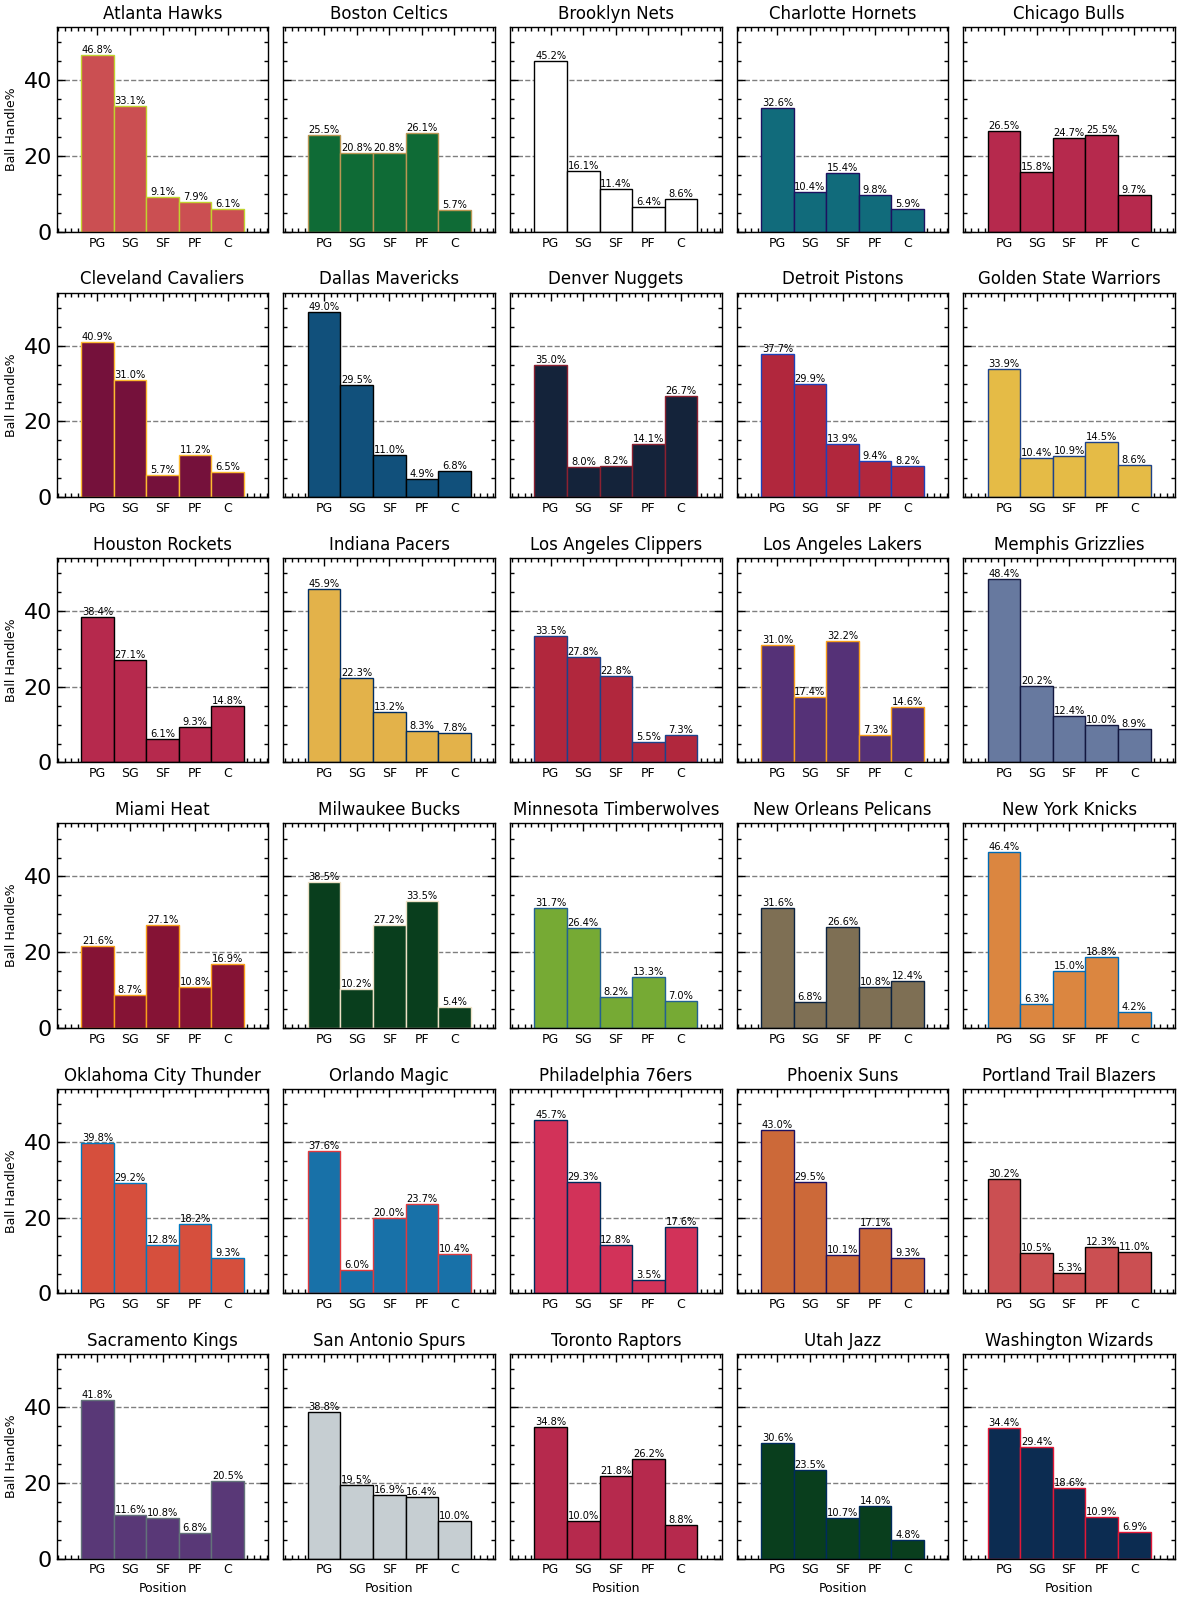

In [217]:
# create figure
fig, axes = plt.subplots(6, 5, figsize=(12, 18))

# set default values for graph creation
max_value = ballhog_starters_df['BALL_HANDLE%'].max() + 5
custom_order = ['PG', 'SG', 'SF', 'PF', 'C']
bar_width = 1

# open json-mapping of team colors as dictionaries
r_main = open('assets/colors.json')
team_colors = json.load(r_main)

r_alt = open('assets/alt-colors.json')
team_alt_colors = json.load(r_alt)

for i in range(len(sorted_team_lst)):
    # row and col index
    row = i // 5
    col = i % 5
    
    # get team info to use
    team_id = sorted_team_lst[i]['id']
    team_name = sorted_team_lst[i]['full_name']
    team_abb = sorted_team_lst[i]['abbreviation']
    
    # get team bar and edge color from dictionary color mapping
    bar_color = team_colors[team_abb]
    edge_color = team_alt_colors[team_abb]
    
    # subset dataframe by team and sort it by position
    team_df = ballhog_starters_df[ballhog_starters_df['TEAM_ID'] == team_id].reset_index(drop=True)
    team_df = team_df.sort_values(by=['POSITION'], key=lambda x: x.map({pos: i for i, pos in enumerate(custom_order)})).reset_index(drop=True)
    
    # create the barplot
    sns.barplot(ax=axes[row, col], data=team_df, x='POSITION', y='BALL_HANDLE%', width=bar_width, color=bar_color, edgecolor=edge_color)
    
    # create margins on the left-handmost and right-handmost bars, default y-max value for all graphs, margins, and team_name as title
    axes[row, col].set_xlim([-1.25, len(custom_order) + 0.25])  # Adjust the x-axis limits
    axes[row, col].set_ylim([0, max_value])
    axes[row, col].set_title(team_name, fontsize=12)
    
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), fontsize=9)
    axes[row, col].bar_label(axes[row, col].containers[0], fmt='%.1f%%', fontsize=7.1)

    # show Y-Axis label only on the left-handmost graph
    if col != 0:
        axes[row, col].set(yticklabels=[])
        axes[row, col].set_ylabel('')
    else:
        axes[row, col].set_ylabel('Ball Handle%', fontsize=9)
        
    # show X-Axis label only the right-handmost graph
    if row != 5:
        axes[row, col].set_xlabel('')
    else:
        axes[row, col].set_xlabel('Position', fontsize=9)
        
# plt.suptitle('Ball Handle Rates by NBA Team - Regular Season 2022-23', fontweight='bold')

#fig.savefig('figures/2022-23_ball_hog_rates_by_team.png', dpi=300)

plt.tight_layout(rect=[0, 0, 1, 0.90], h_pad=1.5)
plt.show()

#### 

#### How have On-Ball Responsibilities for Positions have Changed in the Modern-Era

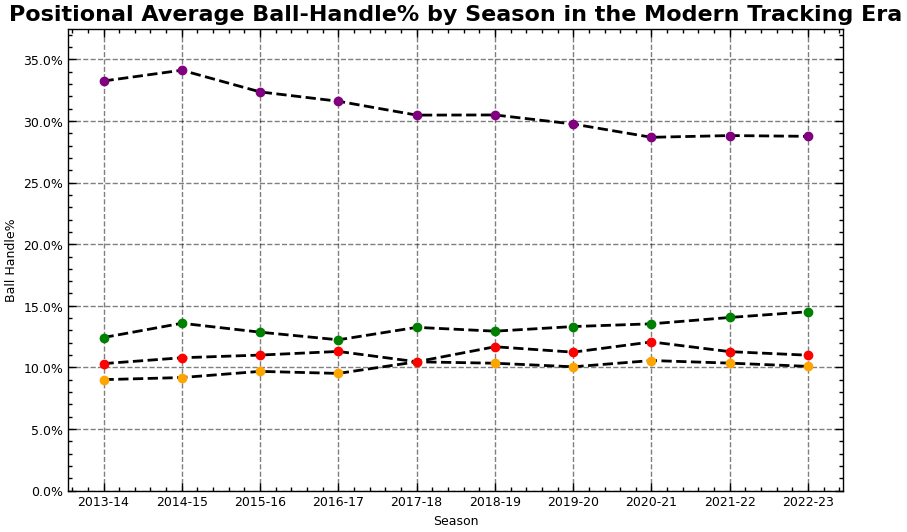

In [197]:
# find group averages of ball-hog 
guards_avg_by_season = guards_df[['SEASON','BALL_HANDLE%']].groupby(by=['SEASON']).mean().reset_index()
bigs_avg_by_season = bigs_df[['SEASON','BALL_HANDLE%']].groupby(by=['SEASON']).mean().reset_index()
gwings_avg_by_season = gwings_df[['SEASON','BALL_HANDLE%']].groupby(by=['SEASON']).mean().reset_index()
bwings_avg_by_season = bwings_df[['SEASON','BALL_HANDLE%']].groupby(by=['SEASON']).mean().reset_index()

# create figure
fig = plt.figure(figsize=(10,6))
ax = plt.gca()

# plot trends by group
plt.scatter(guards_avg_by_season['SEASON'], guards_avg_by_season['BALL_HANDLE%'], zorder=2, color='purple')
plt.plot(guards_avg_by_season['SEASON'], guards_avg_by_season['BALL_HANDLE%'], linestyle='dashed', color='black', zorder=1)

plt.scatter(bigs_avg_by_season['SEASON'], bigs_avg_by_season['BALL_HANDLE%'], zorder=2, color='orange')
plt.plot(bigs_avg_by_season['SEASON'], bigs_avg_by_season['BALL_HANDLE%'], linestyle='dashed', color='black', zorder=1)

plt.scatter(gwings_avg_by_season['SEASON'], gwings_avg_by_season['BALL_HANDLE%'], zorder=2, color='green')
plt.plot(gwings_avg_by_season['SEASON'], gwings_avg_by_season['BALL_HANDLE%'], linestyle='dashed', color='black', zorder=1)

plt.scatter(bwings_avg_by_season['SEASON'], bwings_avg_by_season['BALL_HANDLE%'], zorder=2, color='red')
plt.plot(bwings_avg_by_season['SEASON'], bwings_avg_by_season['BALL_HANDLE%'], linestyle='dashed', color='black', zorder=1)

# edit and modify graph to liking
plt.xlabel('Season', fontsize=9)
plt.ylabel('Ball Handle%', fontsize=9)
plt.ylim(0,37.5)
plt.title('Positional Average Ball-Handle% by Season in the Modern Tracking Era', fontweight='bold')
plt.xticks(fontsize=9)

# format the y-axis
formatter = ticker.FormatStrFormatter('%.1f%%')
ax.yaxis.set_major_formatter(formatter)
ax.tick_params(axis='y', labelsize=9)

plt.show()

In [220]:
# define key variables for data tracking
ranges = [0, 10, 17.5, 35, 52.5]
labels = ['0-10%', '10-17.5%', '17.5-35%', '35%+']

# initialize dataframe to keep trcak on
totals_df = pd.DataFrame(columns=['SEASON'] + labels)

# group the dataframe by season and ball-handle ranges, and keep track of totals by season
for season in sorted(list(guards_df['SEASON'].unique())):
    season_df = guards_df[guards_df['SEASON'] == season].reset_index(drop=True)
    season_df['BALL_HANDLE_RANGE'] = pd.cut(season_df['BALL_HANDLE%'], bins=ranges, labels=labels, right=False)
    grouped_df = season_df.groupby('BALL_HANDLE_RANGE').size().reset_index()
    grouped_df = grouped_df.transpose().drop('BALL_HANDLE_RANGE')
    grouped_df.columns = labels
    totals_df = pd.concat([totals_df, grouped_df]).reset_index(drop=True)
    
# create season column
totals_df['SEASON'] = [str(season) + '-' + str(season+1)[2:] for season in range(2013, 2023)]

totals_df.columns = ['SEASON','Low-Dominance','Mid-Usage', '# of Semi-Ball Dominant Guards', '# of Ball-Dominant Guards']
    
totals_df.drop(columns=['Low-Dominance','Mid-Usage']).to_csv('data/data-wrapper/seasonal_totals_guards_ball_hog_dominance_2013-23.csv', index=False)

totals_df['TOTAL'] = totals_df['Low-Dominance'] + totals_df['Mid-Usage'] + totals_df['# of Semi-Ball Dominant Guards'] + totals_df['# of Ball-Dominant Guards']
    
# see the data
totals_df

,SEASON,Low-Dominance,Mid-Usage,# of Semi-Ball Dominant Guards,# of Ball-Dominant Guards,TOTAL
0,2013-14,2,8,35,49,94
1,2014-15,3,10,33,58,104
2,2015-16,3,6,41,46,96
3,2016-17,4,11,35,40,90
4,2017-18,7,8,45,38,98
5,2018-19,2,11,51,35,99
6,2019-20,4,14,46,30,94
7,2020-21,5,11,51,34,101
8,2021-22,9,8,58,31,106
9,2022-23,7,11,61,29,108


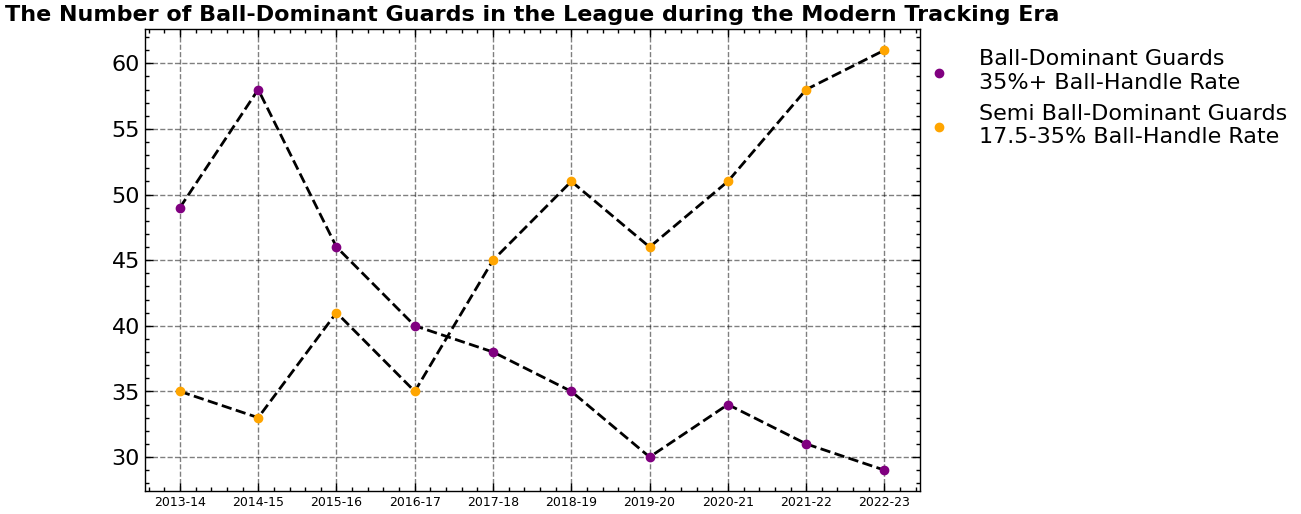

In [208]:
# create figure
fig = plt.figure(figsize=(10,6))
ax = plt.gca()

# plot trends by groupings
plt.scatter(totals_df['SEASON'], totals_df['35%+'], zorder=2, color='purple', label='Ball-Dominant Guards\n35%+ Ball-Handle Rate')
plt.plot(totals_df['SEASON'], totals_df['35%+'], linestyle='dashed', color='black', zorder=1)

plt.scatter(totals_df['SEASON'], totals_df['17.5-35%'], zorder=2, color='orange', label='Semi Ball-Dominant Guards\n17.5-35% Ball-Handle Rate')
plt.plot(totals_df['SEASON'], totals_df['17.5-35%'], linestyle='dashed', color='black', zorder=1)

# plt.scatter(totals_df['SEASON'], totals_df['10-17.5%'], zorder=2, color='green')
# plt.plot(totals_df['SEASON'], totals_df['10-17.5%'], linestyle='dashed', color='black', zorder=1)

# plt.scatter(totals_df['SEASON'], totals_df['0-10%'], zorder=2, color='red')
# plt.plot(totals_df['SEASON'], totals_df['0-10%'], linestyle='dashed', color='black', zorder=1)

# plt.ylim(25, 35)
# plt.ylim(0,37.5)
plt.title('The Number of Ball-Dominant Guards in the League during the Modern Tracking Era', fontweight='bold')
plt.xticks(fontsize=9)

plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

fig.savefig('figures/frequency_ball_dominant_guards_trend_2013-23.png', dpi=300)

plt.show()

#### Guard Age Curves

In [233]:
avg_by_age = guards_df[['AGE','BALL_HANDLE%']].groupby(by='AGE').mean().reset_index()
avg_by_exp = guards_df[['EXP','BALL_HANDLE%']].groupby(by='EXP').mean().reset_index()

In [240]:
guards_df[guards_df['AGE'] == 35]

,SEASON,MINUTES_ON,PLAYER_NAME,PLAYER_ID,TEAM_ID,SECONDS_PER_POSS_OFFENSE_PLAYER_ON,TIME_OF_POSS,TEAM,OFF_POSS,BALL_HANDLE%,AGE,EXP,POS_EST
118,2022-23,1276,Mike Conley,201144.0,1610612762,15.082,265.1,UTA,2607.0,40.5,35.0,15.0,1.00
119,2022-23,718,Mike Conley,201144.0,1610612750,14.988,122.2,MIN,1541.0,31.7,35.0,15.0,1.03
151,2020-21,1601,Kyle Lowry,200768.0,1610612761,14.013,240.3,TOR,3323.0,31.0,35.0,14.0,1.08
171,2019-20,2316,LeBron James,2544.0,1610612747,14.258,496.4,LAL,4790.0,43.6,35.0,16.0,1.52
235,2020-21,1528,Garrett Temple,202066.0,1610612741,14.470,65.4,CHI,3180.0,8.5,35.0,10.0,1.75
384,2020-21,1337,Goran Dragic,201609.0,1610612748,14.855,216.8,MIA,2683.0,32.6,35.0,12.0,1.33
398,2019-20,2208,Chris Paul,101108.0,1610612760,14.559,431.3,OKC,4520.0,39.3,35.0,14.0,1.00
451,2022-23,1919,Stephen Curry,201939.0,1610612744,13.508,318.7,GSW,4174.0,33.9,35.0,13.0,1.00
669,2021-22,799,Lou Williams,101150.0,1610612737,15.055,102.0,ATL,1605.0,25.3,35.0,16.0,1.16
766,2018-19,752,J.J. Barea,200826.0,1610612742,14.765,188.3,DAL,1565.0,48.9,35.0,12.0,1.00


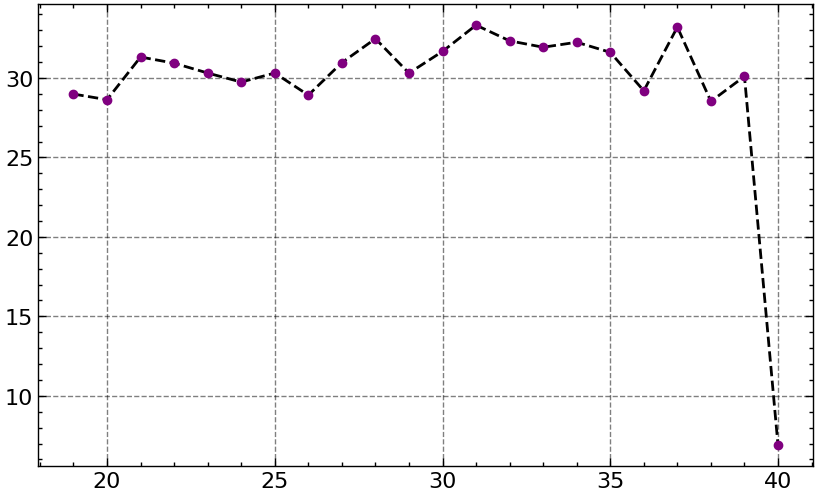

In [243]:
# create figure
fig = plt.figure(figsize=(10,6))
ax = plt.gca()

# plot trends by groupings
plt.scatter(avg_by_age['AGE'], avg_by_age['BALL_HANDLE%'], zorder=2, color='purple')
plt.plot(avg_by_age['AGE'], avg_by_age['BALL_HANDLE%'], linestyle='dashed', color='black', zorder=1)

plt.show()

In [313]:
guards_df[guards_df['EXP'] == 14]

,SEASON,MINUTES_ON,PLAYER_NAME,PLAYER_ID,TEAM_ID,SECONDS_PER_POSS_OFFENSE_PLAYER_ON,TIME_OF_POSS,TEAM,OFF_POSS,BALL_HANDLE%,AGE,EXP,POS_EST
110,2021-22,2058,Mike Conley,201144.0,1610612762,15.230,391.4,UTA,4108.0,37.5,34.0,14.0,1.00
151,2020-21,1601,Kyle Lowry,200768.0,1610612761,14.013,240.3,TOR,3323.0,31.0,35.0,14.0,1.08
211,2022-23,526,Eric Gordon,201569.0,1610612746,14.486,33.2,LAC,1140.0,12.1,34.0,14.0,1.66
227,2022-23,667,George Hill,201588.0,1610612749,15.252,88.3,MIL,1361.0,25.5,37.0,14.0,1.23
392,2022-23,787,Goran Dragic,201609.0,1610612741,13.919,120.1,CHI,1644.0,31.5,37.0,14.0,1.00
398,2019-20,2208,Chris Paul,101108.0,1610612760,14.559,431.3,OKC,4520.0,39.3,35.0,14.0,1.00
474,2022-23,1491,Russell Westbrook,201566.0,1610612747,13.756,285.8,LAL,3205.0,38.9,34.0,14.0,1.33
475,2022-23,595,Russell Westbrook,201566.0,1610612746,14.342,106.7,LAC,1331.0,33.5,34.0,14.0,1.08
662,2019-20,1864,Lou Williams,101150.0,1610612746,13.645,323.8,LAC,4014.0,35.5,33.0,14.0,1.00
793,2017-18,1069,Dwyane Wade,2548.0,1610612739,14.299,147.6,CLE,2199.0,28.2,36.0,14.0,1.18


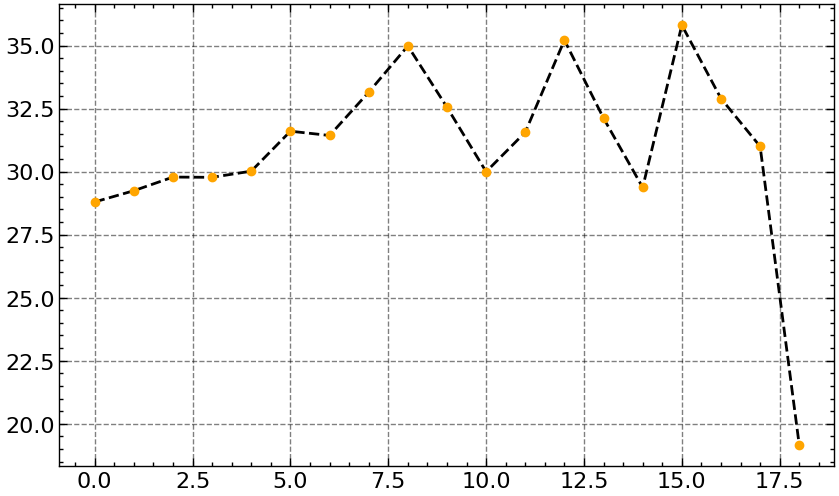

In [244]:
# create age
fig = plt.figure(figsize=(10,6))
ax = plt.gca()

# plot trends by experience
plt.scatter(avg_by_exp['EXP'], avg_by_exp['BALL_HANDLE%'], zorder=2, color='orange')
plt.plot(avg_by_exp['EXP'], avg_by_exp['BALL_HANDLE%'], linestyle='dashed', color='black', zorder=1)

plt.show()

#### Show Ball-Handle Percentage Groupings by Season

<Axes: xlabel='MINUTES_ON', ylabel='Count'>

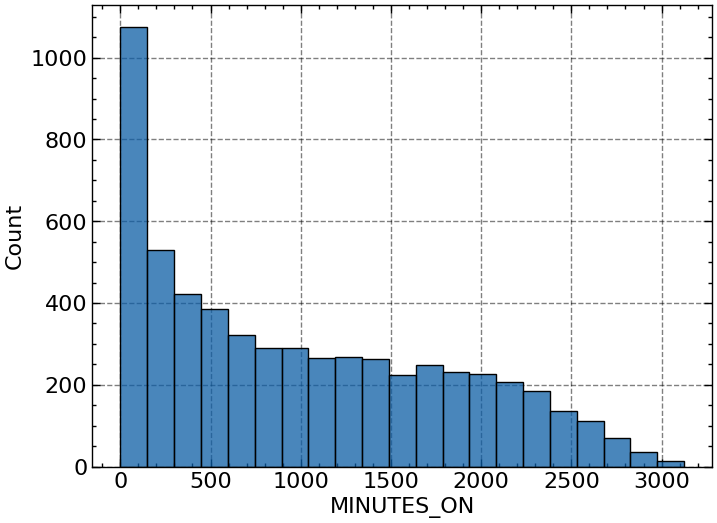

In [398]:
sns.histplot(data=ballhog_df, x='MINUTES_ON')

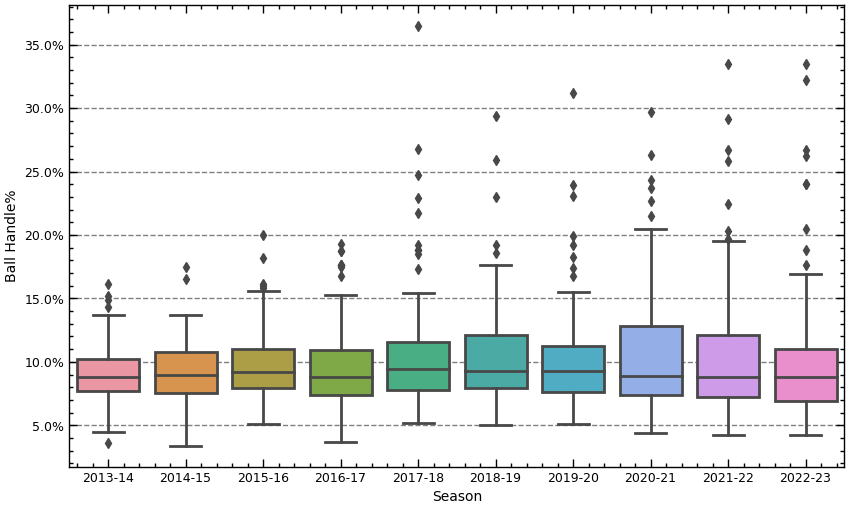

In [156]:
filtered_df = ballhog_df[ballhog_df['MINUTES_ON'] >= 1000]

fig = plt.figure(figsize=(10,6))
ax = plt.gca()

sns.boxplot(data=bigs_df, x='SEASON', y='BALL_HANDLE%', order=sorted(list(filtered_df['SEASON'].unique())))
#sns.barplot(ax=axes[row, col], data=team_df, x='POSITION', y='BALL_HANDLE%', width=bar_width, color=bar_color, edgecolor=edge_color)
plt.title('')
plt.xlabel('Season', fontsize=10)
plt.ylabel('Ball Handle%', fontsize=10)
plt.xticks(fontsize=9)

# format the y-axis
formatter = ticker.FormatStrFormatter('%.1f%%')
ax.yaxis.set_major_formatter(formatter)
ax.tick_params(axis='y', labelsize=9)

# plt.ylim(min_value-2.5, max_value+2.5)

plt.show()

#### Points vs. Ball-Handle Skill Curves(?)

In [449]:
player_totals_df = pd.read_csv('data/possessions/player_possessions_by_team_season_2013-23.csv')

per100_df = player_totals_df.copy()
per100_df = per100_df[['SEASON','PLAYER_ID','TEAM','OffPoss','Points']]
per100_df['PTS_PER_100'] = round(per100_df['Points'] / per100_df['OffPoss'] * 100, 1)
per100_df['TEAM_ID'] = per100_df['TEAM'].map(abb_to_id_map)

per100_df.head()

,SEASON,PLAYER_ID,TEAM,OffPoss,Points,PTS_PER_100,TEAM_ID
0,2013-14,708,BKN,2072,352,17.0,1610612751
1,2013-14,951,MIA,3637,701,19.3,1610612748
2,2013-14,959,LAL,656,102,15.5,1610612747
3,2013-14,965,OKC,2804,425,15.2,1610612760
4,2013-14,977,LAL,357,83,23.2,1610612747


<Axes: xlabel='BALL_HANDLE%', ylabel='PTS_PER_100'>

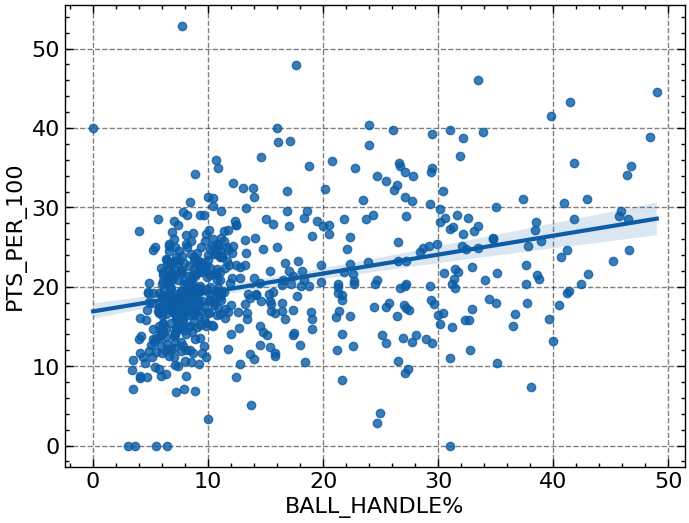

In [452]:
test = pd.merge(current_players, per100_df[['SEASON','PLAYER_ID','TEAM_ID','PTS_PER_100']], on=['SEASON','PLAYER_ID','TEAM_ID'], how='left')
sns.regplot(data=test, x='BALL_HANDLE%', y='PTS_PER_100')


<Axes: xlabel='BALL_HANDLE%', ylabel='PTS_PER_100'>

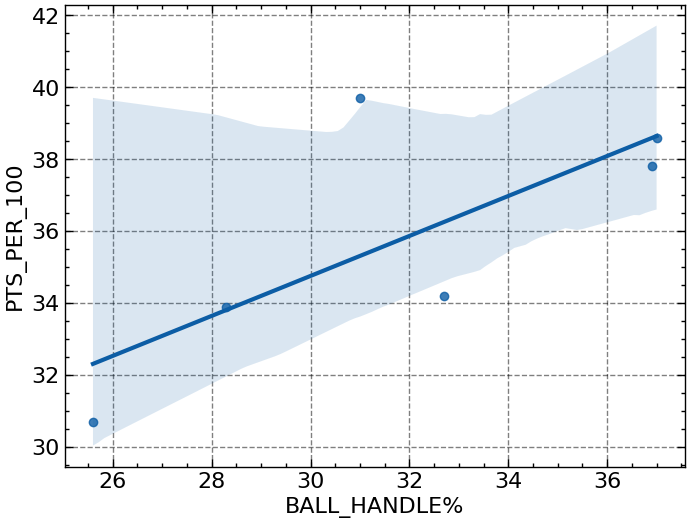

In [472]:
test = pd.merge(ballhog_df, per100_df[['SEASON','PLAYER_ID','TEAM_ID','PTS_PER_100']], on=['SEASON','PLAYER_ID','TEAM_ID'], how='left')
test = test[test['PLAYER_NAME'] == 'Donovan Mitchell']
sns.regplot(data=test, x='BALL_HANDLE%', y='PTS_PER_100')

In [470]:
test = pd.merge(ballhog_df, per100_df[['SEASON','PLAYER_ID','TEAM_ID','PTS_PER_100']], on=['SEASON','PLAYER_ID','TEAM_ID'], how='left')
test['PTS_HANDLE_RATIO'] = round(test['PTS_PER_100'] / test['BALL_HANDLE%'], 2)
test = test[test['BALL_HANDLE%'] >= 25]
test = test[test['MINUTES_ON'] >= 500]
test.sort_values(by=['PTS_HANDLE_RATIO'], ascending=False).head(30)

,SEASON,MINUTES_ON,PLAYER_NAME,PLAYER_ID,TEAM_ID,SECONDS_PER_POSS_OFFENSE_PLAYER_ON,TIME_OF_POSS,TEAM,OFF_POSS,BALL_HANDLE%,PTS_PER_100,PTS_HANDLE_RATIO
514,2019-20,2053,Bradley Beal,203078.0,1610612764,14.044,257.3,WAS,4374.0,25.1,39.8,1.59
4263,2021-22,2476,Nikola Jokic,203999.0,1610612743,14.705,320.7,DEN,5065.0,25.8,39.6,1.53
2594,2022-23,2732,Jayson Tatum,1628369.0,1610612738,14.743,358.0,BOS,5587.0,26.1,39.8,1.52
1924,2021-22,2204,Giannis Antetokounmpo,203507.0,1610612749,13.549,303.6,MIL,4618.0,29.1,43.4,1.49
2593,2021-22,2731,Jayson Tatum,1628369.0,1610612738,14.919,348.8,BOS,5462.0,25.7,37.5,1.46
4262,2020-21,2488,Nikola Jokic,203999.0,1610612743,15.119,333.0,DEN,5021.0,26.3,37.8,1.44
1922,2019-20,1917,Giannis Antetokounmpo,203507.0,1610612749,12.851,280.9,MIL,4206.0,31.2,44.2,1.42
3602,2016-17,1403,Lou Williams,101150.0,1610612747,14.374,181.6,LAL,2904.0,26.1,37.1,1.42
1258,2016-17,2620,DeMar DeRozan,201942.0,1610612761,15.461,377.1,TOR,5203.0,28.1,38.8,1.38
3277,2018-19,2702,Kevin Durant,201142.0,1610612744,13.237,325.7,GSW,5714.0,25.8,35.5,1.38


#### Show Ball-Handle Percentage Trends for Star-Players

In [299]:
# open json-mapping of team colors as dictionaries
r_main = open('assets/colors.json')
team_colors = json.load(r_main)

def show_player__progression(player_df):
    # get default values
    player_name = player_df['PLAYER_NAME'].unique()[0]
    
    colors = [team_colors[team_abb] if team_abb != 'BKN' else "#c6cfd4" for team_abb in player_df['TEAM'].to_list()]
    seasons = player_df['SEASON'].to_list()
    team_order = [player_df.loc[num, 'TEAM'] for num in player_df['ORDER'].to_list()]
    
    min_value = player_df['BALL_HANDLE%'].min()
    max_value = player_df['BALL_HANDLE%'].max()
    
    # create figure
    fig = plt.figure(figsize=(10,6))
    ax = plt.gca()
    
    # plot line and points
    plt.scatter(player_df['ORDER'], player_df['BALL_HANDLE%'], c=colors, s=50, zorder=2)
    plt.plot(player_df['ORDER'], player_df['BALL_HANDLE%'], linestyle='dashed', zorder=1, color='black', alpha=0.75)
    
    # customize the plot with labels, ticks, and limits
    plt.title("{}'s Ball Handle% by Season | NBA Regular Season".format(player_name), fontsize=12, fontweight='bold')
    plt.xlabel('Season', fontsize=10)
    plt.ylabel('Ball Handle%', fontsize=10)
    plt.xticks(player_df['ORDER'].to_list(), seasons, fontsize=9)
    plt.ylim(min_value-2.5, max_value+2.5)
    
    # format the y-axis
    formatter = ticker.FormatStrFormatter('%.1f%%')
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='y', labelsize=9)
    
    # label each marker point
    for x, y, value, team in zip(player_df['ORDER'], player_df['BALL_HANDLE%'], player_df['BALL_HANDLE%'], player_df['TEAM']):
        ax.annotate('{:.1f}%\n{}'.format(value, team), (x, y+.12), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    
    return fig, ax

def show_multiple_player_hog_progression(player_names, df):
    # create figure
    fig = plt.figure(figsize=(10,6))
    ax = plt.gca()
    
    # loop through players and plot them
    for player_name in player_names:
        player_df = df[df['PLAYER_NAME'].str.contains(player_name)]
        
        # get default values
        colors = [team_colors[team_abb] if team_abb != 'BKN' else "#c6cfd4" for team_abb in player_df['TEAM'].to_list()]
        seasons = player_df['SEASON'].to_list()
        # team_order = [player_df.loc[num, 'TEAM'] for num in player_df['SEASON'].to_list()]
    
        # plot line and points
        plt.scatter(player_df['SEASON'], player_df['BALL_HANDLE%'], c=colors, s=50, zorder=2)
        plt.plot(player_df['SEASON'], player_df['BALL_HANDLE%'], linestyle='dashed', zorder=1, color='black', alpha=0.75)
        seasons = sorted(list(df['SEASON'].unique()))
        plt.xticks([1,2,3,4,5,6,7,8,9,10], seasons, fontsize=9)
    
    # customize the plot with labels, ticks, and limits
    plt.title("Star Guards' Ball-Hog% by Season | NBA Regular Season", fontsize=12, fontweight='bold')
    plt.xlabel('Season', fontsize=10)
    plt.ylabel('Ball Hog%', fontsize=10)
    plt.xticks(fontsize=9)
    # plt.ylim(min_value-2.5, max_value+2.5)
    seasons = sorted(list(df['SEASON'].unique()))
    print(len(seasons))
    plt.xticks([1,2,3,4,5,6,7,8,9,10], seasons, fontsize=9)
    
    # format the y-axis
    formatter = ticker.FormatStrFormatter('%.1f%%')
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='y', labelsize=9)
    
    # plt.legend()
    
    # label each marker point
    # for x, y, value, team in zip(player_df['ORDER'], player_df['BALL_HANDLE%'], player_df['BALL_HANDLE%'], player_df['TEAM']):
    #     ax.annotate('{:.1f}%\n{}'.format(value, team), (x, y+.12), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    
    return fig, ax

10


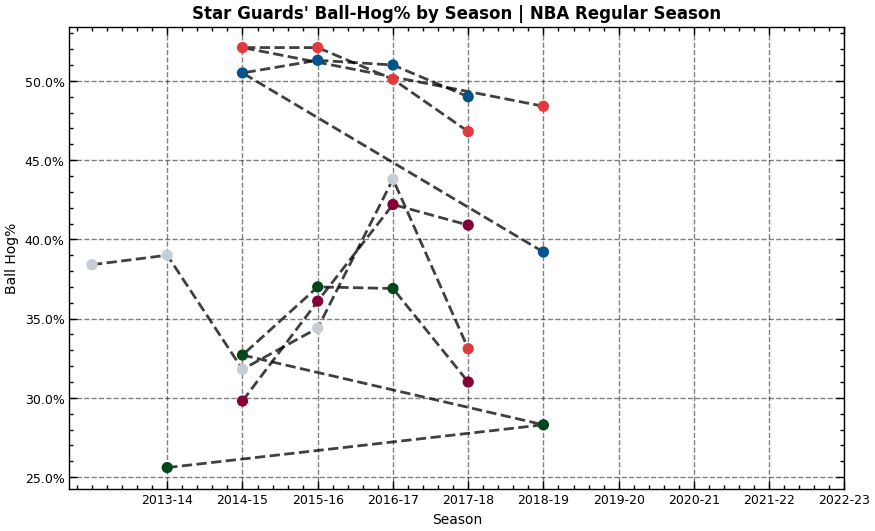

In [300]:
fig, ax = show_multiple_player_hog_progression(['Dejounte Murray','Donovan Mitchell', 'Darius Garland',
                                                   'Trae Young', 'Luka Doncic',#'Dejounte Murray',
                                                  ],
                                                  ballhog_df.sort_values(by=['SEASON']))

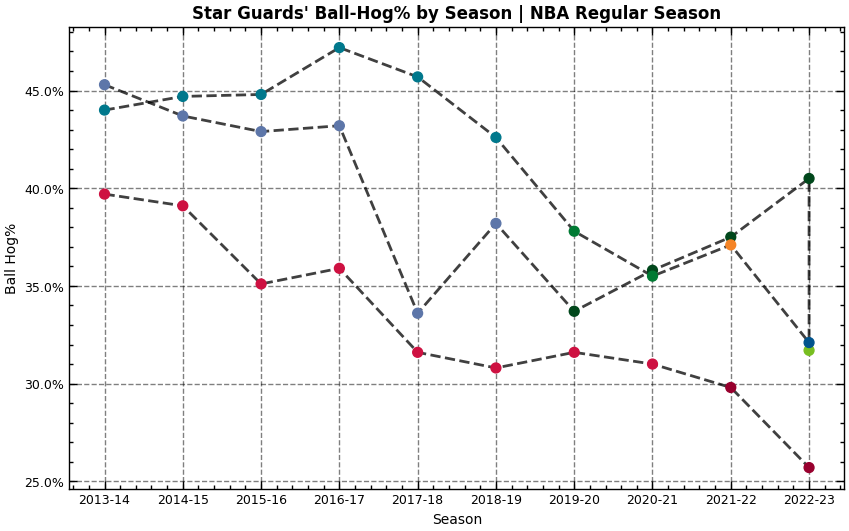

In [291]:
fig, ax = show_multiple_player_hog_progression(['Mike Conley',
                                                   #"D'Angelo Russell",
                                                   #'Jrue Holiday',
                                                   'Kyle Lowry', 
                                                   'Kemba Walker',
                                                
                                                   #'Donovan Mitchell', 
                                                   #'Damian Lillard',
                                                   #'Trae Young', 'Luka Doncic'
                                                  ],
                                                  ballhog_df.sort_values(by=['SEASON']))

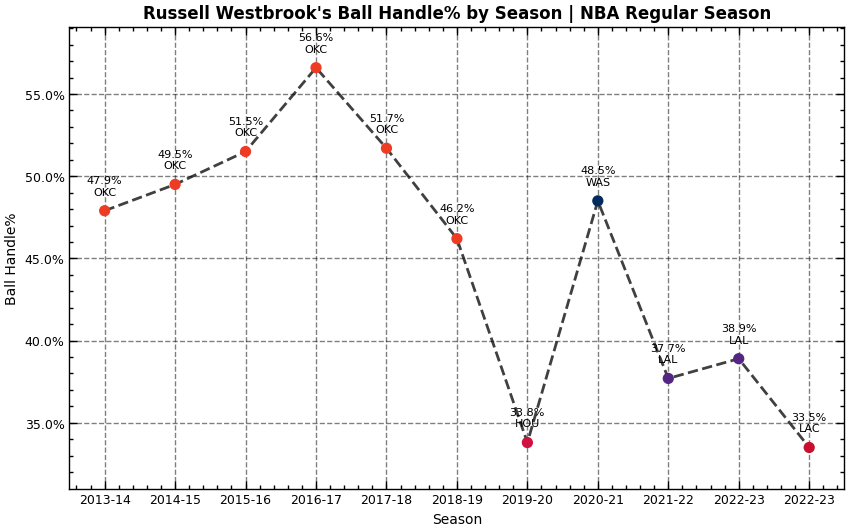

In [402]:
# get westbrook data
westbrook_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Russell Westbrook')].reset_index(drop=True)

# account for the switch of teams and order the dataframe accordingly
order = list(westbrook_df.index.values)
order = order[:-2] + [order[-1]] + [order[-2]]
westbrook_df['ORDER'] = order
westbrook_df = westbrook_df.sort_values(by=['ORDER']).reset_index(drop=True)

fig.savefig('figures/westbrook_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(westbrook_df)

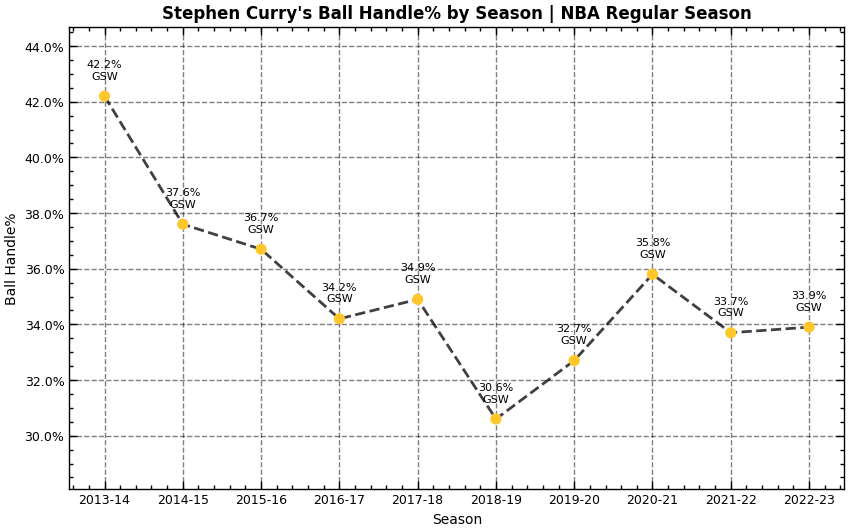

In [403]:
# get curry data
curry_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Stephen Curry')].reset_index(drop=True)
order = list(curry_df.index.values)
curry_df['ORDER'] = order

fig.savefig('figures/curry_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(curry_df)

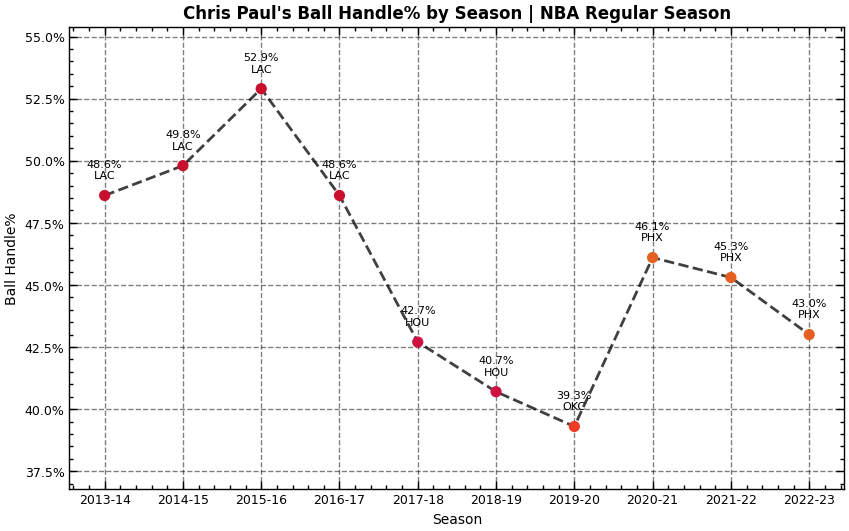

In [404]:
# get cp3 data
cp3_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Chris Paul')].reset_index(drop=True)
order = list(cp3_df.index.values)
cp3_df['ORDER'] = order

fig.savefig('figures/cp3_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(cp3_df)

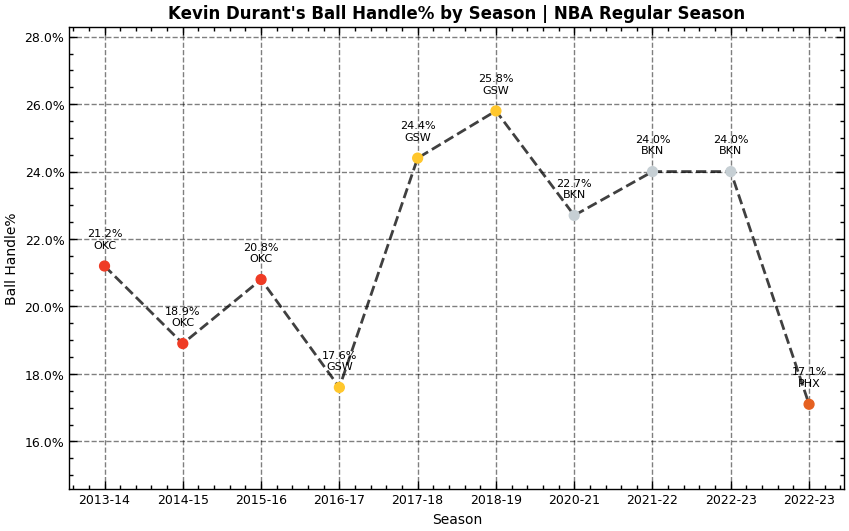

In [405]:
# get durant data
kd_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Kevin Durant')].reset_index(drop=True)
order = list(kd_df.index.values)
kd_df['ORDER'] = order

fig.savefig('figures/durant_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(kd_df)

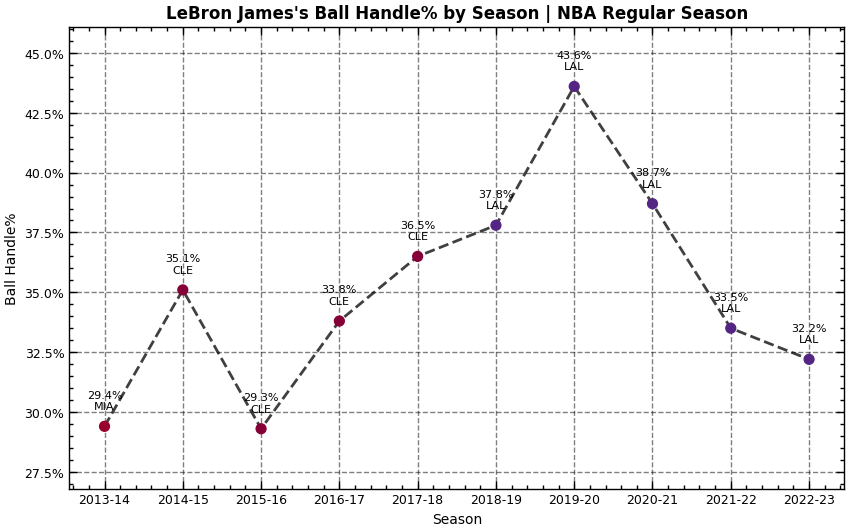

In [406]:
# get lebron data
lbj_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('LeBron James')].reset_index(drop=True)
order = list(lbj_df.index.values)
lbj_df['ORDER'] = order

fig.savefig('figures/lebron_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(lbj_df)

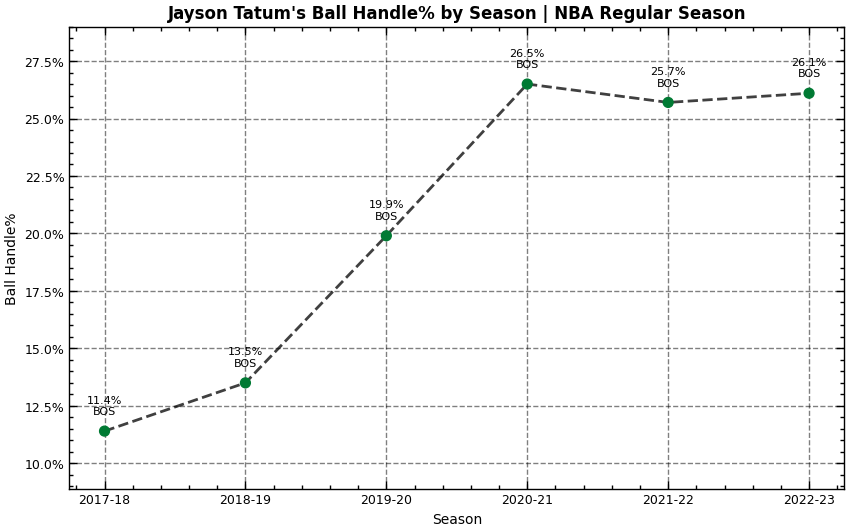

In [407]:
# get tatum data
tatum_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Jayson Tatum')].reset_index(drop=True)
order = list(tatum_df.index.values)
tatum_df['ORDER'] = order

fig.savefig('figures/tatum_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(tatum_df)

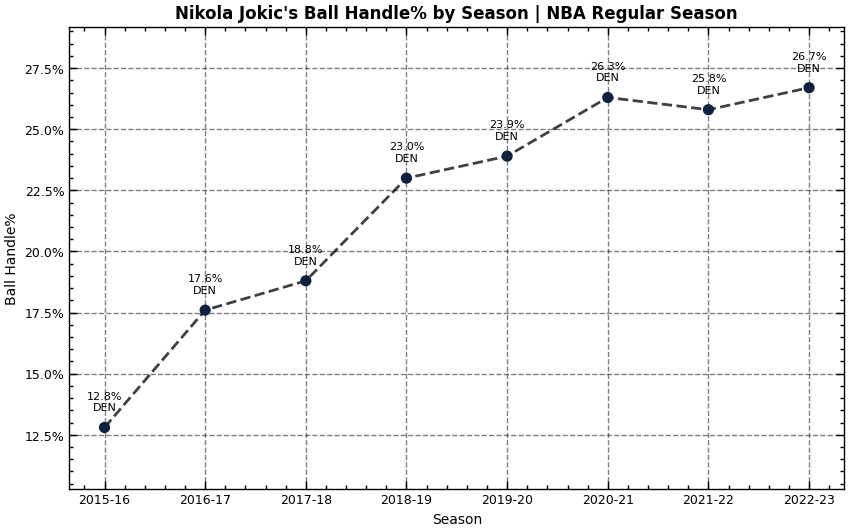

In [408]:
# get jokic data
jokic_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Nikola Jokic')].reset_index(drop=True)
order = list(jokic_df.index.values)
jokic_df['ORDER'] = order

fig.savefig('figures/jokic_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(jokic_df)

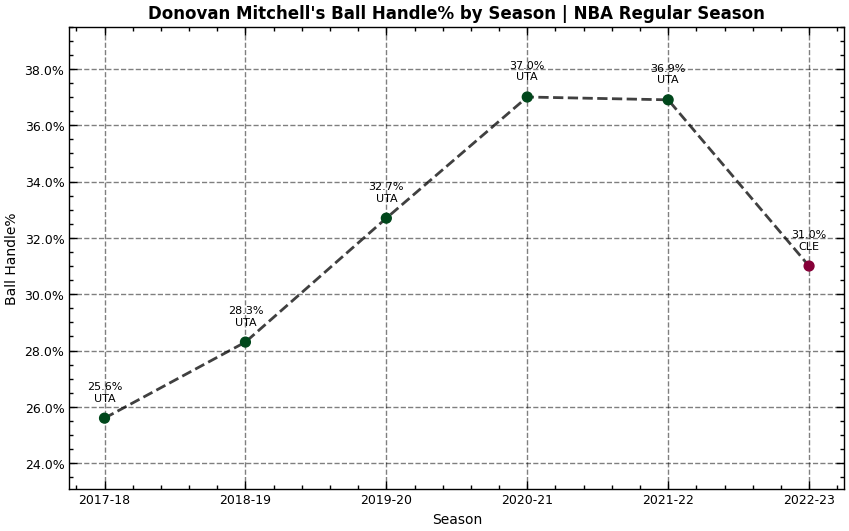

In [409]:
# get mitchell data
mitchell_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Donovan Mitchell')].reset_index(drop=True)
order = list(mitchell_df.index.values)
mitchell_df['ORDER'] = order

fig.savefig('figures/mitchell_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(mitchell_df)

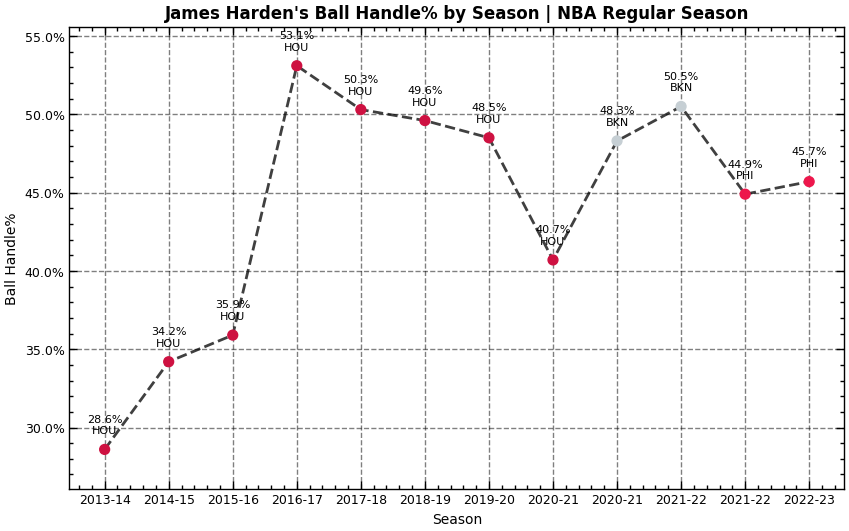

In [418]:
# get harden data
harden_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('James Harden')].reset_index(drop=True)
order = list(harden_df.index.values)
harden_df['ORDER'] = order

fig.savefig('figures/harden_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(harden_df)

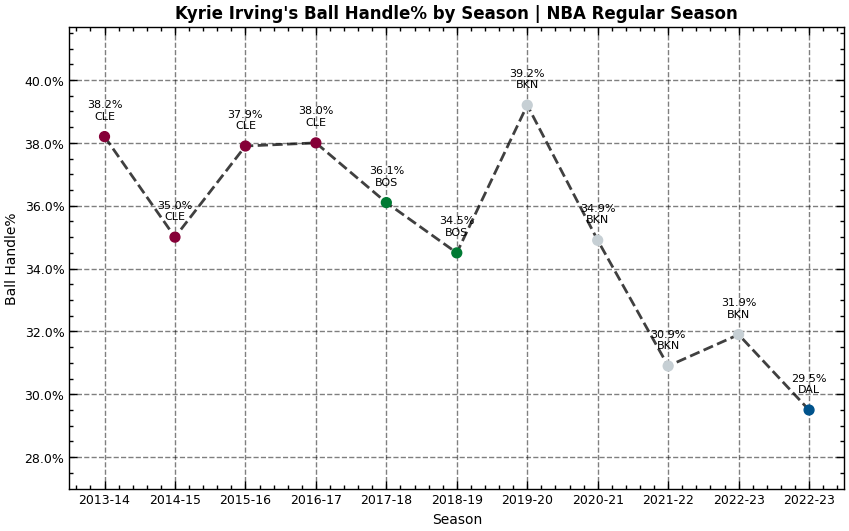

In [440]:
# get irving data
irving_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Kyrie Irving')].reset_index(drop=True)

# account for the switch of teams and order the dataframe accordingly
order = list(irving_df.index.values)
order = order[:-2] + [order[-1]] + [order[-2]]
irving_df['ORDER'] = order
irving_df = irving_df.sort_values(by=['ORDER']).reset_index(drop=True)

fig.savefig('figures/irving_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(irving_df)

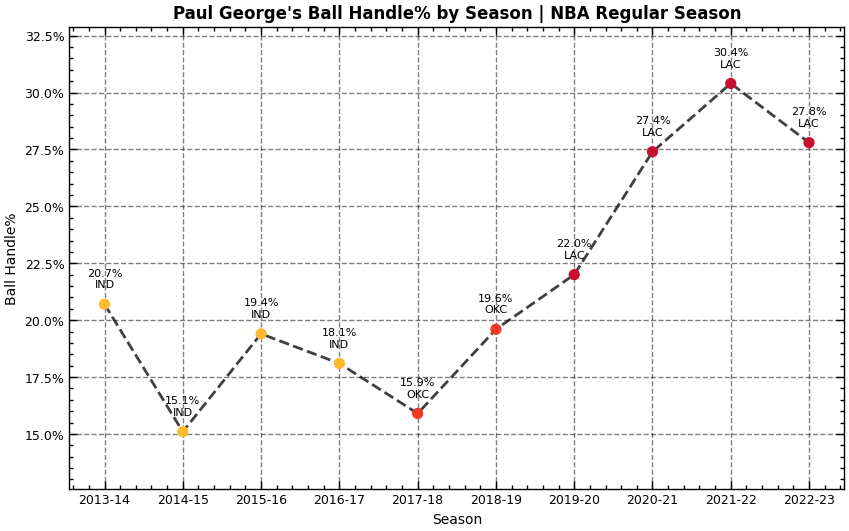

In [419]:
# get pg13 data
pg13_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Paul George')].reset_index(drop=True)
order = list(pg13_df.index.values)
pg13_df['ORDER'] = order

fig.savefig('figures/pg13_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(pg13_df)

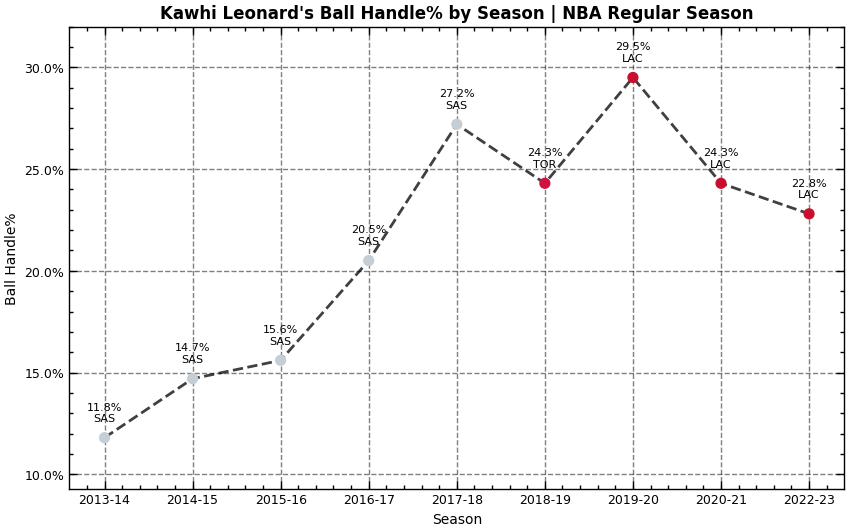

In [517]:
# get butler data
leonard_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Kawhi Leonard')].reset_index(drop=True)
order = list(leonard_df.index.values)
leonard_df['ORDER'] = order

fig.savefig('figures/leonard_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(leonard_df)

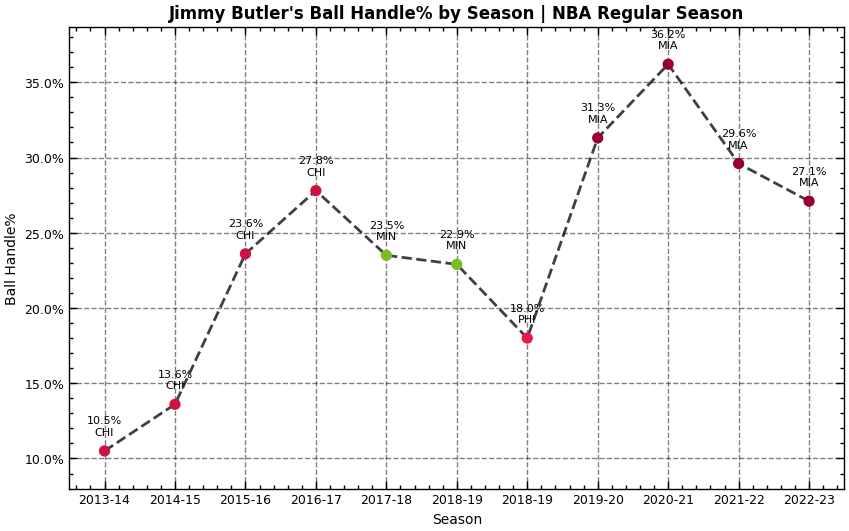

In [420]:
# get butler data
butler_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Jimmy B')].reset_index(drop=True)
order = list(butler_df.index.values)
butler_df['ORDER'] = order

fig.savefig('figures/butler_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(butler_df)

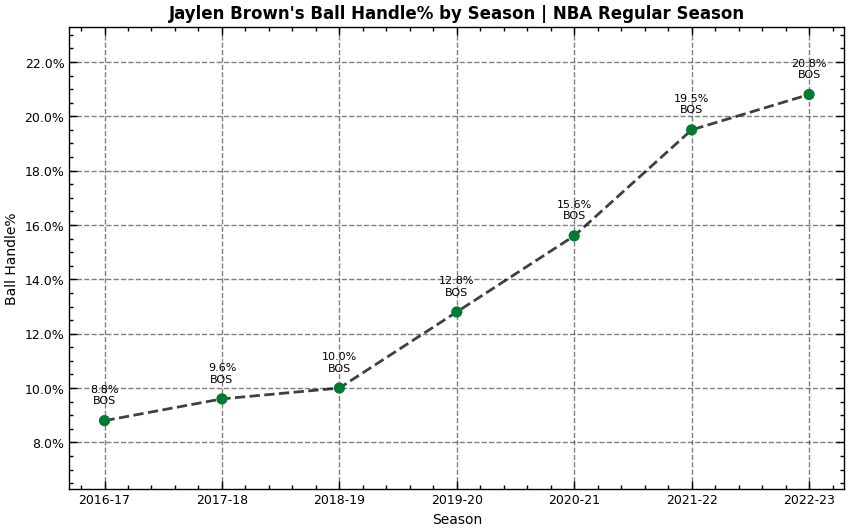

In [434]:
# get butler's data
butler_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Jaylen B')].reset_index(drop=True)
order = list(butler_df.index.values)
butler_df['ORDER'] = order

fig.savefig('figures/butler_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(butler_df)

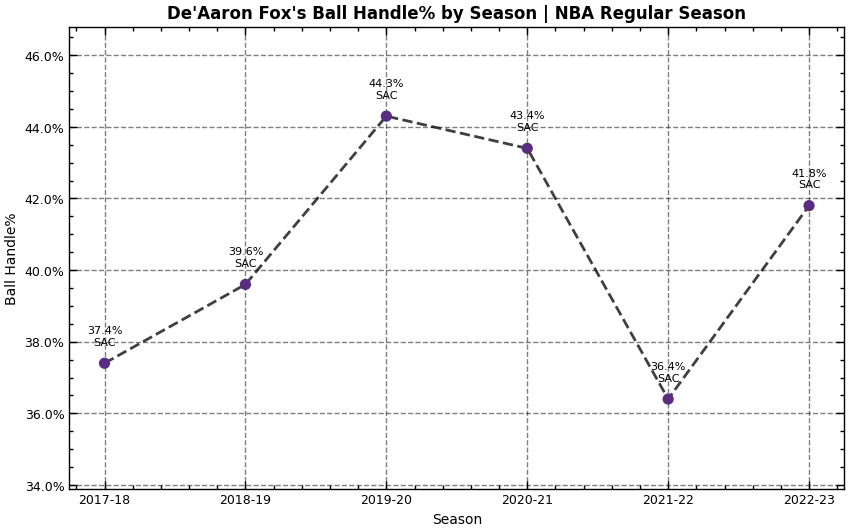

In [439]:
# get fox data
fox_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Fox')].reset_index(drop=True)
order = list(fox_df.index.values)
fox_df['ORDER'] = order

fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(fox_df)

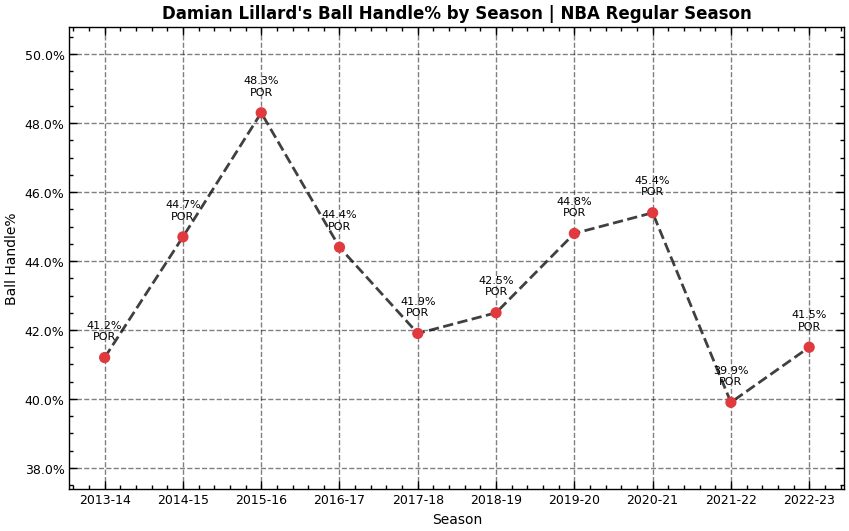

In [498]:
# get lillard data
lillard_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Damian Lillard')].reset_index(drop=True)
order = list(lillard_df.index.values)
lillard_df['ORDER'] = order

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(lillard_df)

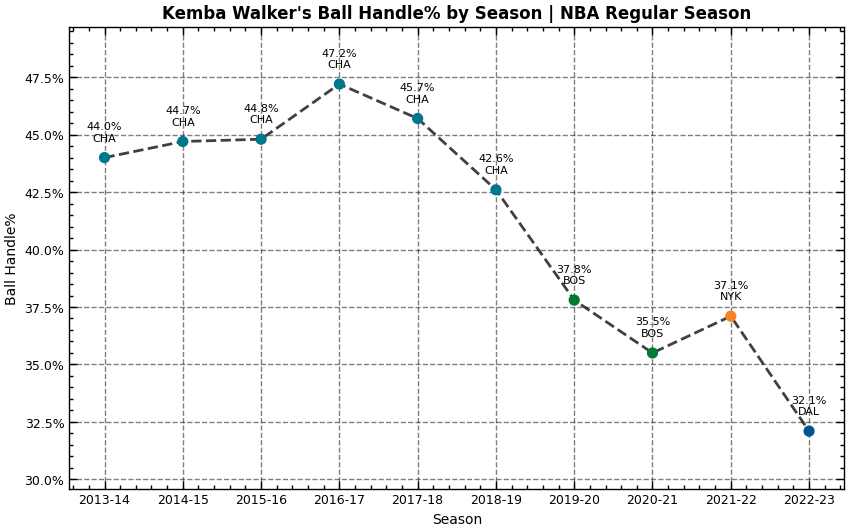

In [499]:
# get kemba data
walker_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Kemba Walker')].reset_index(drop=True)
order = list(walker_df.index.values)
walker_df['ORDER'] = order

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(walker_df)

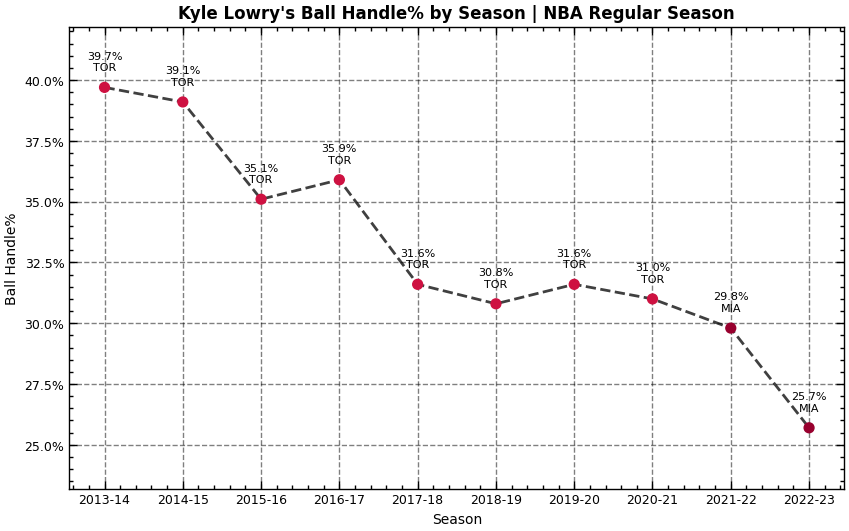

In [500]:
# get lowry data
lowry_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Kyle Lowry')].reset_index(drop=True)
order = list(lowry_df.index.values)
lowry_df['ORDER'] = order

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(lowry_df)

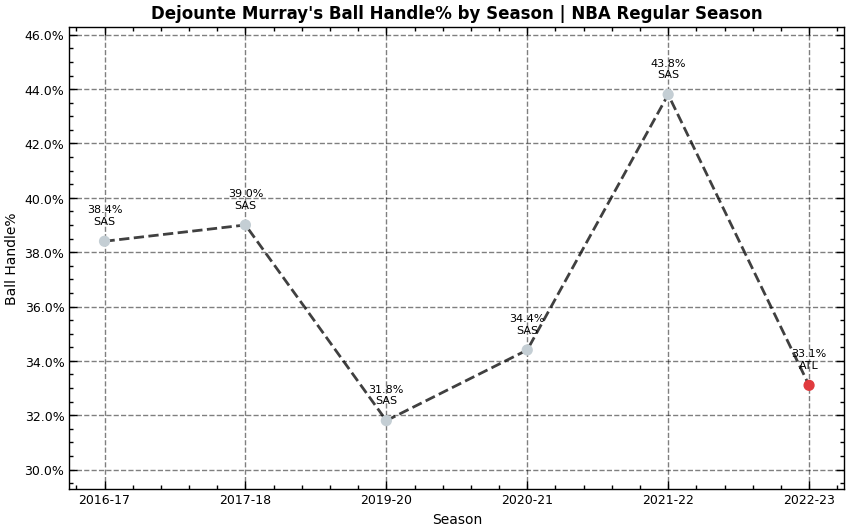

In [508]:
# get murray data
murray_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Dejounte Murray')].reset_index(drop=True)
order = list(murray_df.index.values)
murray_df['ORDER'] = order

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(murray_df)

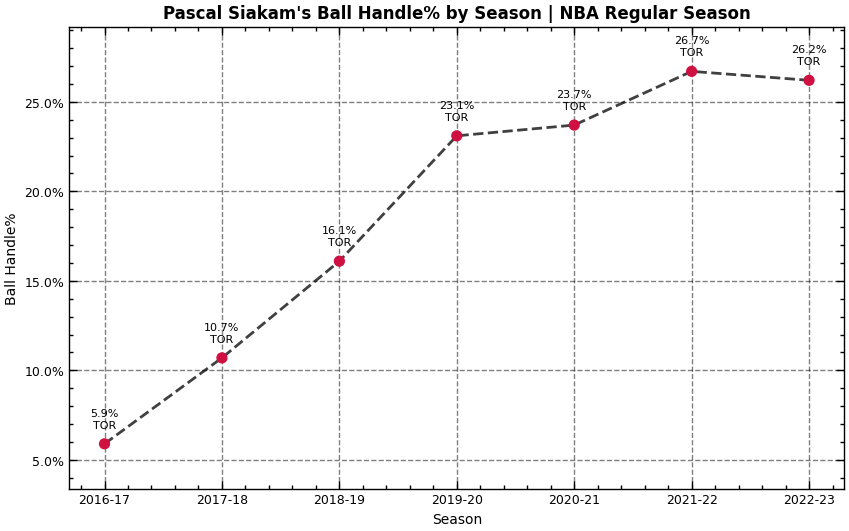

In [509]:
# get siakam data
siakam_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Pascal Siakam')].reset_index(drop=True)
order = list(siakam_df.index.values)
siakam_df['ORDER'] = order

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(siakam_df)

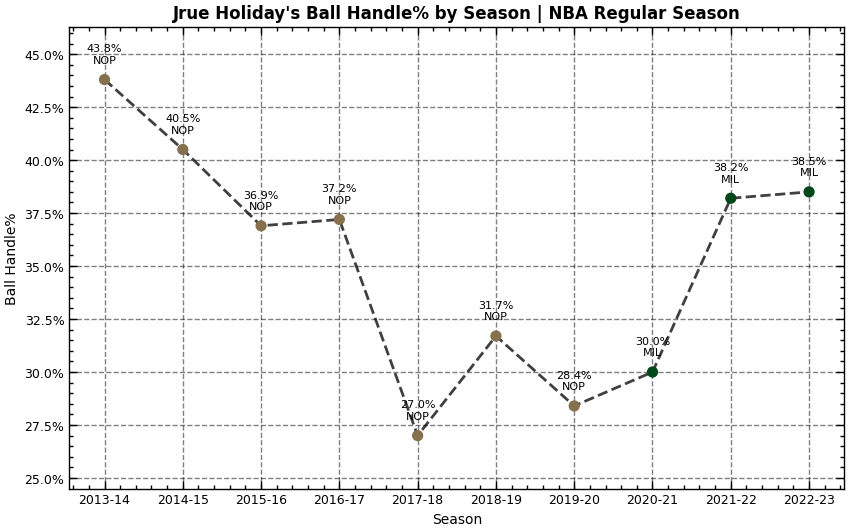

In [510]:
# get holiday data
holiday_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Jrue Holiday')].reset_index(drop=True)
order = list(holiday_df.index.values)
holiday_df['ORDER'] = order

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(holiday_df)

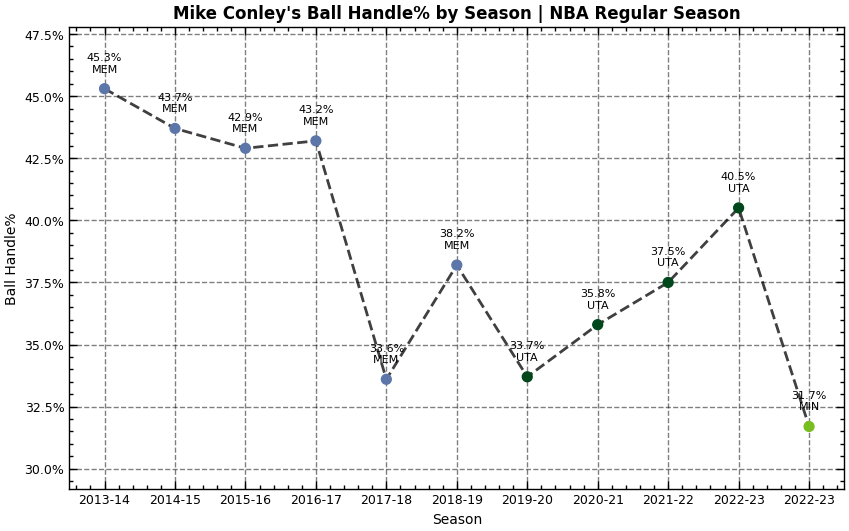

In [511]:
# get conley data
conley_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Mike Conley')].reset_index(drop=True)

# account for the switch of teams and order the dataframe accordingly
order = list(conley_df.index.values)
order = order[:-2] + [order[-1]] + [order[-2]]
conley_df['ORDER'] = order
conley_df = conley_df.sort_values(by=['ORDER']).reset_index(drop=True)

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(conley_df)

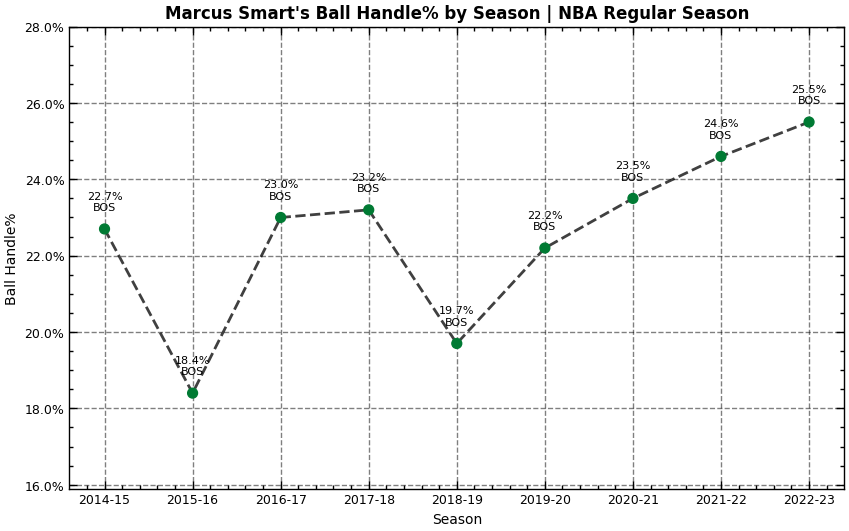

In [519]:
# get conley data
smart_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains('Marcus Smart')].reset_index(drop=True)

# account for the switch of teams and order the dataframe accordingly
order = list(smart_df.index.values)
smart_df['ORDER'] = order

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(smart_df)

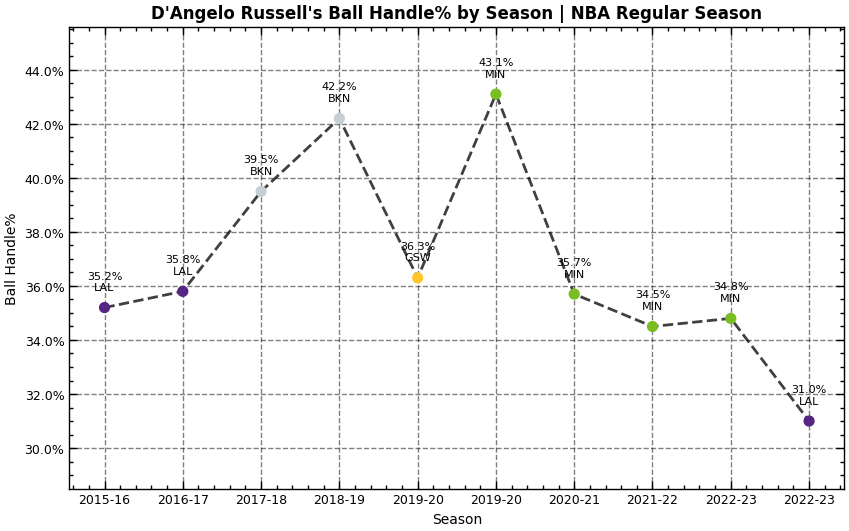

In [514]:
# get d'angelo data
dlo_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains("D'Angelo Russell")].reset_index(drop=True)

# account for the switch of teams and order the dataframe accordingly
order = list(dlo_df.index.values)
order = order[:-2] + [order[-1]] + [order[-2]]
dlo_df['ORDER'] = order
dlo_df = dlo_df.sort_values(by=['ORDER']).reset_index(drop=True)

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(dlo_df)

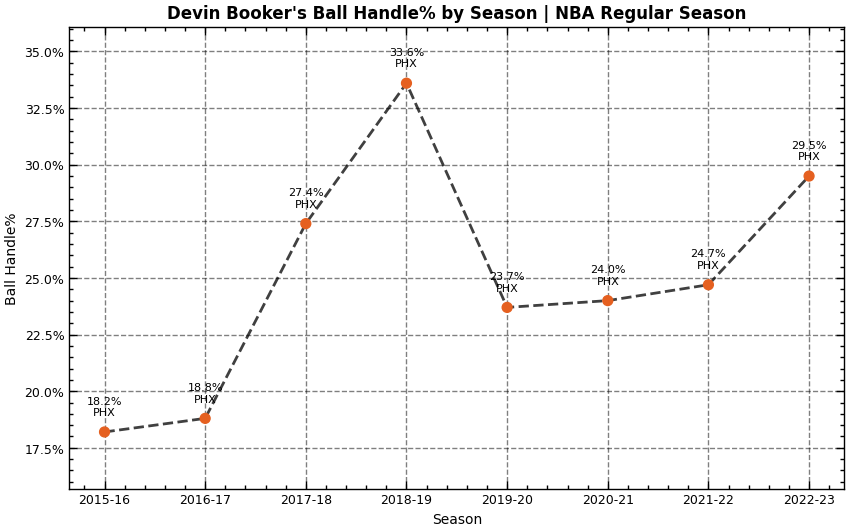

In [520]:
# get d'angelo data
booker_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains("Devin Booker")].reset_index(drop=True)

# account for the switch of teams and order the dataframe accordingly
order = list(booker_df.index.values)
booker_df['ORDER'] = order

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(booker_df)

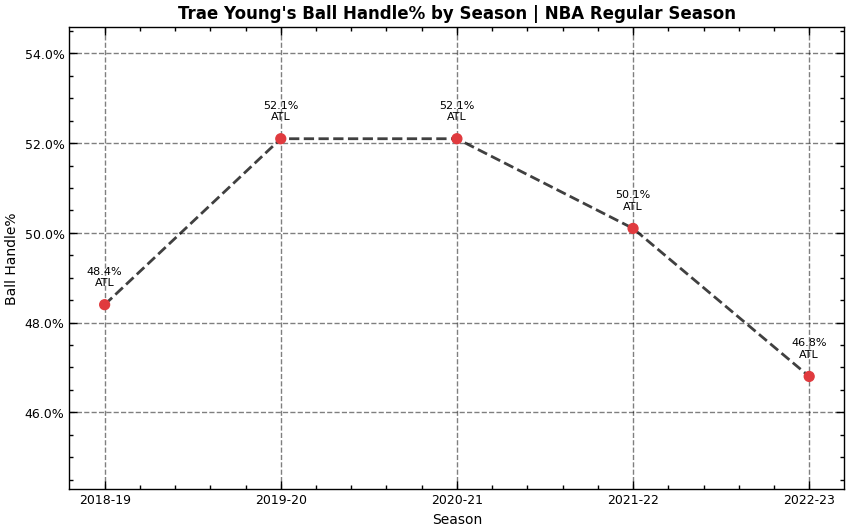

In [252]:
# get d'angelo data
young_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains("Trae Young")].sort_values(by=['SEASON']).reset_index(drop=True)

order = list(young_df.index.values)
young_df['ORDER'] = order

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(young_df)

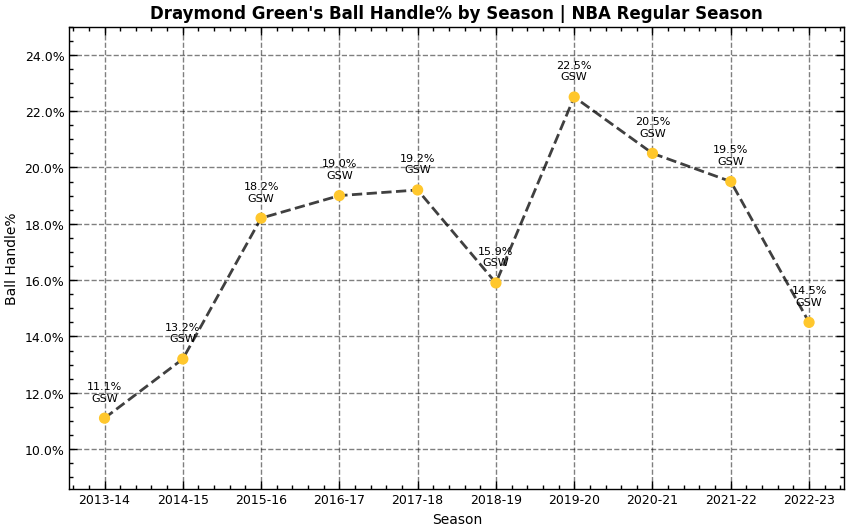

In [302]:
# get d'angelo data
young_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains("Draymond Green")].sort_values(by=['SEASON']).reset_index(drop=True)

order = list(young_df.index.values)
young_df['ORDER'] = order

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(young_df)

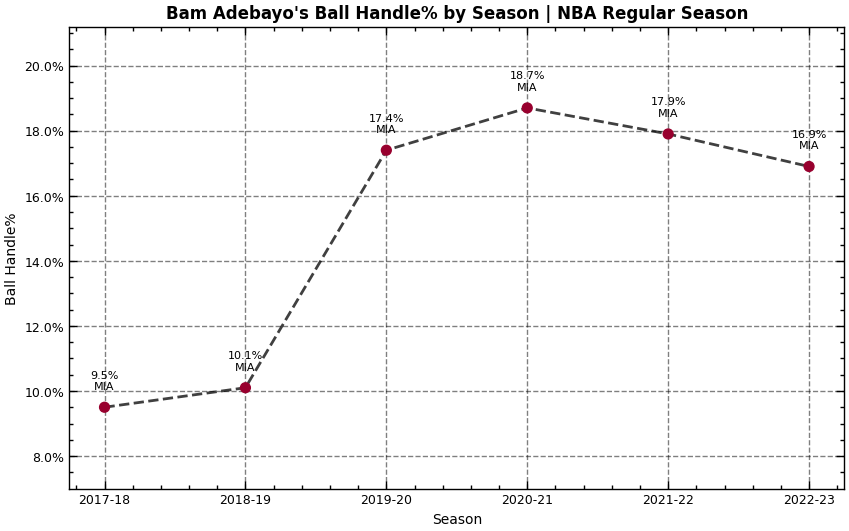

In [303]:
# get d'angelo data
young_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains("Bam Adebayo")].sort_values(by=['SEASON']).reset_index(drop=True)

order = list(young_df.index.values)
young_df['ORDER'] = order

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(young_df)

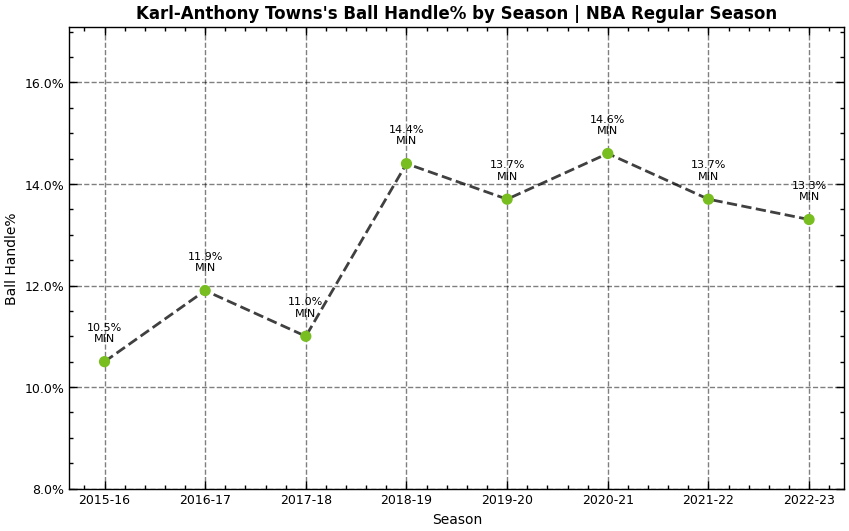

In [305]:
# get d'angelo data
young_df = ballhog_df[ballhog_df['PLAYER_NAME'].str.contains("Towns")].sort_values(by=['SEASON']).reset_index(drop=True)

order = list(young_df.index.values)
young_df['ORDER'] = order

# fig.savefig('figures/fox_rs_hog_progression_2013-23.png', dpi=300)

# plot is ball handle % by season
fig, ax = show_player_hog_progression(young_df)